kendi girdiğimiz yorumun olumlu mu olumsuz mu olduğunu anlicaz

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

In [11]:
max_features = 10000 #en cok kullanılan kelimeler
maxlen = 100 # her yorumun maximum uzunlugu

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [12]:
# yorum uzunlgun max 100 kelime oalrak ayarla
x_train = pad_sequences(x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)
# Verinin boyutlarına bakalım
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [13]:
word_index = imdb.get_word_index()

In [18]:
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [19]:
# kelime dizini ters cevirelim
reverse_word_index = {index + 3 : word for word, index in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

In [20]:
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i, "?") for i in encoded_review])

In [22]:
# rastgele 3 kelime yazalım
random_indices = np.random.choice(len(x_train), size=3, replace=False)
for i in random_indices:
    print(f"Yorum: {decode_review(x_train[i])}")
    print(f"Etiket: {y_train[i]}")
    print()

Yorum: he is br br the twist is well handled but the handling is straight out of 80's the <UNK> <UNK> comedy which entertains here and there stands out as a sore thumb as it doesn't fit in the story br br even there are several <UNK> scenes br br direction by raj <UNK> is adequate though at times too melodramatic music is okay but most songs look forced br br anil does his part well <UNK> is excellent in her part <UNK> is decent amongst rest <UNK> khan is as usual <UNK> <UNK> is funny <UNK> <UNK> <UNK> is decent
Etiket: 0

Yorum: the skills of murphy on this show the impressions are excellent the skits are great and the timing is perfect you can even tell the crowd gets really into when he did raw a few years later it was also really good but this is 1 in my book also shows that at one time particularly the early to mid eighties that murphy was funny my favorite parts of the show is when he is retelling the family <UNK> and ice cream <UNK> the ice cream man is coming another great part

Transformer Layers

In [23]:
# trasnformer mimariisndeki bi blok yapı sınıfı
# Bu blok self atention ve feed forwerd aını birleştirecek
class TransformerBlock(layers.Layer):
    
    #embeSzie: giristeki embeded vektorleirn boyutu
    #head: mutli head atentoin mekansizmalarında kullanılcak olan baslık sayisi
    # dropout_rate: agirliklarin sifirlanma orani overfittingi engelleme yontemlerinden biri
    def __init__(self, embed_size, heads,  droput_rate = 0.3):
        
        # ust sinifimiz olan layers.layer sinifinin init metodunu cagirarak temel katman ozellikleri sahip oluyoruz
        super(TransformerBlock, self).__init__()
        
        # multi head idkkat mekanizması
        #num_heads : baslik sayisi (ayni anda kac farkli dikkat hsaplamsı yapabileceğimizi belirleyen parametre)
        #key_dim : her dikkat basliginde kullailan anahtar boyutu
        self.attention = layers.MultiHeadAttention(num_heads = heads, key_dim = embed_size)
        
        #normalization katmani: epsikon sayisal kararlilik artirmak icin kllanilir
        self.norm1 = layers.LayerNormalization(epsilon=1e-6) #10 uzeri -6
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.feed_forward = models.Sequential([layers.Dense(embed_size * heads, activation = "relu"), layers.Dense(embed_size)]) # cikis tekrar orijinal embed sayisina getirir

        #overgittingi engellemek için yapılan katman
        self.dropout1 = layers.Dropout(droput_rate)
        self.dropout2 = layers.Dropout(droput_rate)

    # call : giris nasil islenildigini tanimla yanii transformer islevi
    # x: giris vektoru
    # trining: egitim sirasinda drop out uygulanmasini belirle
    def call(self, x, training):
        # self atention mekanizasi: her kelimenin diger keliemelr ile baglam iliskilerini ogrenir
        attention = self.attention(x, x) #
        
        # residual baglantisi (skip connection)
        # attention ciktisi orijinal giris olan x ile toplanir
        x = self.norm1(x + self.dropout1(attention, training))

        # feed forward agi
        feed_forward = self.feed_forward(x)

        # residual baglanti
        return self.norm2(x + self.dropout2(feed_forward, training = training))

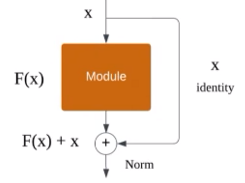

Transfer Modeli Oluşturulması ve Eğitimi

In [24]:
# transfer mimarisini kullanan bir model sinifi
# bu class inputlari alip transformers blokalrindan gecçer, sonra çikiş verielrini sınıflandırır

class TransformerModel(models.Model):
    
    # num_layers: transfer nlokairniin fonksiyonu
    # embed_size : girdi verilerinin embededing boyutu
    # heads: herbir transformer blogundaki multi head attention sayisi
    # input_dim: giristeki olasi kelime sayisi(token sayiis)
    # output_dim: modelin çikişindaki sinif boyutu
    def __init__(self, num_layers, embed_size, heads, input_dim, output_dim, droput_rate= 0.1):
        # üst sınıf olan models.Model sinifindan init metodunu çağirarak temel model ozelliklerini baslatiyoruz 
        super(TransformerModel, self).__init__()
        
        # girdileri(kelime, senbol, token) sayisallaştiriyor(srekli değerlerden oluşan vektörler) 
        self.embedding = layers.Embedding(input_dim= input_dim, output_dim = embed_size)
        
        # birden fazla transforme blogu olusturur
        # num_layers kadar transformer blogu olusturur
        self.transformer_blocks = [TransformerBlock(embed_size, heads, droput_rate) for _ in range(num_layers)]
        
        # global ortlama havuz katmani
        self.global_Avg_pooling = layers.GlobalAveragePooling1D()

        self.dropout = layers.Dropout(droput_rate)

        # output layer
        # fc: (flully connect layers) tam bağli katman
        self.fc = layers.Dense(output_dim, activation="sigmoid")

    # GİDİNİN MODEL ÜZERİNDEN NASIL İLERLEYECEĞİİ TANIMLAR
    def call(self, x, training):
        # token dizisi eembeding katmanindan gçirilir
        # sonuc oalrak, tokenlar sabit boyutlu vektorlere donusturlur
        x = self.embedding(x)

        # her bir transormer bogu sırayla çalıştıırlır
        for transformer in self.transformer_blocks:
            x = transformer(x, training)
        
        # average pooling
        x = self.global_Avg_pooling(x)

        x=self.dropout(x, training= training)

        # tam bağlı katmana ileterek çıkış katmanı hesaplanılır
        return self.fc(x)

Model Training

In [25]:
# hyper parametre
num_layers = 4 # traasnform layer sayisi
embed_size = 64
num_heads = 4 # mutli head sayisi
input_dim = max_features
output_dim =  1 # ikili sınıflandırma, 0 yada 1 , pozitif yada negatif
dropout_rate = 0.1

In [26]:
# model olusturma
model = TransformerModel(num_layers, embed_size, num_heads, input_dim, output_dim, dropout_rate)

# modeli bir giris verisi ile vagirarak insaa edilme
model.build(input_shape = (None, maxlen))

In [27]:
# compile
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=["accuracy"])

In [28]:
model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  640000    
                                                                 
 transformer_block (Transfo  multiple                  99712     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  multiple                  99712     
 formerBlock)                                                    
                                                                 
 transformer_block_2 (Trans  multiple                  99712     
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  multiple                  99712     
 formerBlock)                                    

In [29]:
history = model.fit(x_train, y_train, epochs = 2, batch_size = 256, validation_data = (x_test, y_test))

Epoch 1/2
98/98 [==============================] - 357s 3s/step - loss: 0.5455 - accuracy: 0.7054 - val_loss: 0.3704 - val_accuracy: 0.8395
Epoch 2/2
98/98 [==============================] - 377s 4s/step - loss: 0.2779 - accuracy: 0.8846 - val_loss: 0.3566 - val_accuracy: 0.8442


Model Test

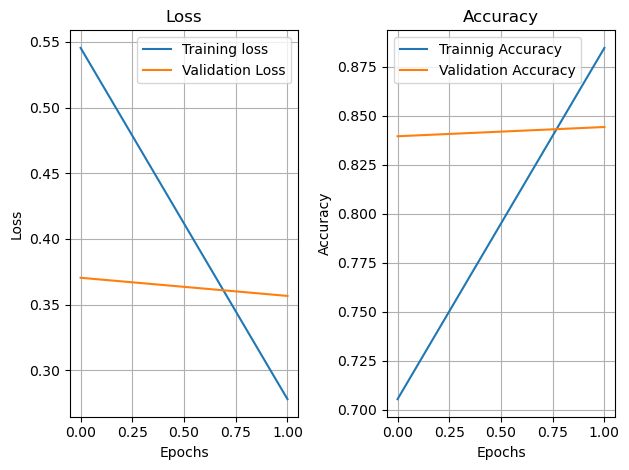

In [30]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label = "Trainnig Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
def predict_sentiment(model, text, word_index, maxlen):
    
    # metnin sayisal formda ceviir
    encoded_text = [word_index.get(word, 0) for word in text.lower().split()] # kelimeleri sayia çeviriyor
    padded_text = pad_sequences([encoded_text], maxlen = maxlen)

    # prediction: modelimiz yorumumuzun olumlu mu olumsuz mu oldugunun tahmin etmeli
    prediction = model.predict(padded_text) #model bir tahmin yap

    return prediction[0][0]

In [32]:
# imdb veri setidndeki kelime dizisi
wod_index = imdb.get_word_index()

In [33]:
user_input = input("Film Yorumu yazin: ")
sentinent_score = predict_sentiment(model, user_input, word_index, maxlen)
print(sentinent_score)

1/1 [==============================] - 1s 1s/step
0.8680209


yourumum: i like it, good films

In [34]:
if sentinent_score > 0.5: #olumlu
    print(f"Tahmin sonunu % {int(round(sentinent_score * 100,0))} olasiligi ile olumlu skor : {sentinent_score}")
else:
    print(f"Tahmin sonunu % {100 - int(round(sentinent_score * 100,0))} olasiligi ile olumsz skor : {sentinent_score}")

Tahmin sonunu % 87 olasiligi ile olumlu skor : 0.8680208921432495


In [ ]:
# model kaydetme 
model.save("yorum_duygu_analizi_model.h5")

In [ ]:
# load model
loaded_model = load_model("yorum_duygu_analizi_model.h5")
test_loss, test_acc = loaded_model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, test_acc: {test_acc}")